<a href="https://colab.research.google.com/github/sanganalasya-hash/Data-Science/blob/main/Copy_of_Unit5ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Exercises: Leverage + Practice with GLMs

In these exercises, we'll focus on:
- how to recognize high leverage values, and what to do about them.
- how to decide when a generalized linear model is better than than an all normal, straight line model

We'll start  by looking at the full NBA data set from class, and interogate why I removed so many observations from that data set.

We'll finish with another classic data set, some deemographic data from the Kalahari !Kung San people collected by Nancy Howell in Botswana between August 1967 and May 1969.

##Leverage

Let's take a look at the full basketball data set.

In [ ]:
#load the data into a pandas dataframe, and print it
url_basketball = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/basketball2324.csv'
#I could have put the url string directly into pd.read_csv()
basketball = pd.read_csv(url_basketball,dtype={'Pos':'category'})

Before, we put a minutes restriction on what players we looked at, and removed anyone who never missed a free throw.

I've commented out that code, for reference, below. We're going to attempt to run the same analysis without removing any data

In [ ]:
#only look at players who played more than 400 minutes
#basketball = basketball.query('MP > 400')
#remove players who never missed a free throw
#basketball = basketball.query('`FT%` != 1.0')

In [ ]:
basketball

**Task1**:

Make a scatter plot with FT% of each player on the horizontal axis and FG% on the vertical axis.

What patterns do you notice? Why do you think they are there?

Text(0, 0.5, 'FG%')

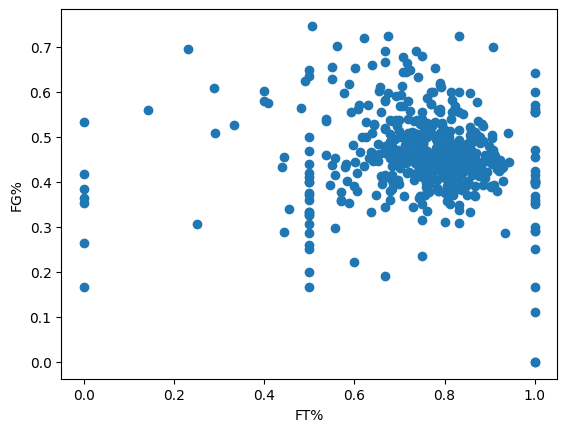

In [ ]:
plt.scatter(basketball['FT%'] , basketball['FG%'],)

#label axes
plt.xlabel("FT%")
plt.ylabel("FG%")

I notice that most of the data is clustered in the upper right quadrant. I think this makes sense --- the players with high FT% would naturally have a higher chance of being able to score points when they score points.

**Task2**:

Make a scatter plot with FT% on the horizontal axis and FG% on the vertical axis. Do this for each each Position in the data set.

Pay special attention to the plots for C and PF.

In [ ]:
#this is an array of the basketball positions,
#except they are given an int (number) label instead of a string (of letters)
pos_idx = basketball.Pos.cat.codes.values

#an array of the strings that represent position
pos_codes = basketball.Pos.cat.categories

#puts coords in a dict, so pymc can read them
bb_coords = {"pos": pos_codes}

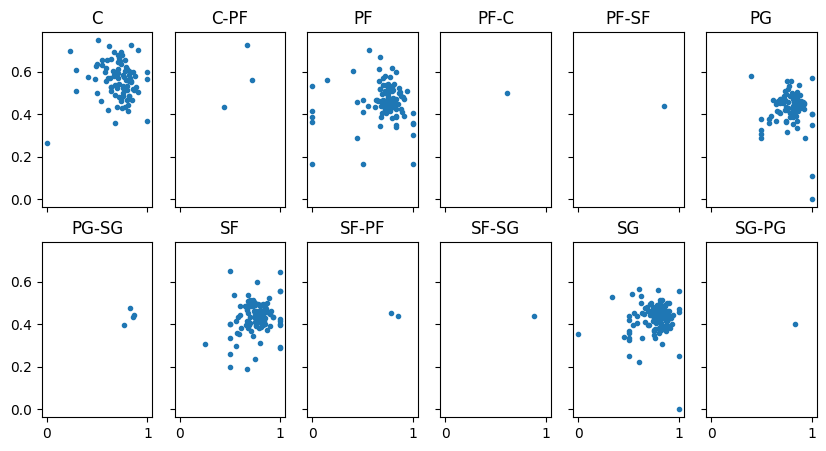

In [ ]:
#set up the 12 plots
_, ax = plt.subplots(2, 6, figsize=(10, 5), sharex=True, sharey=True)
ax = np.ravel(ax)

#make a scatter plot for each position
for i, p in enumerate(pos_codes):
    ax[i].scatter(
        x = basketball.query('Pos == @p')['FT%'],
        y =  basketball.query('Pos == @p')['FG%'],
        marker=".")
    ax[i].set_title(f"{p}")

**Task3**:

Originally, I was going to get you to create and run an individual linear regression model for each of the positions.

But I couldn't even get model to run.

Explain why a linear regression model won't run on the full dataset. HInt: look at the graphs you made above, and compare and contrast them to the ones from class.

Or: if you do what I could not and get a linear regression model to run on the full data set, I'll give you full credit and a high five.

For a linear regression, you need two distinct points to form a line. However, our scatter plot only has really one distinct point/all the data is concentrated in one area. Therefore, the linear regression would give a vertical line which is undefined and therefore would be difficult to run a regression.

## From Linear Model to Generalized Linear Model

You'll now fit a linear regression on the height and weight for people or the Kalahari !Kung San people. Height will be the predictor and weight will be the predicted.

Here's the raw data.

In [3]:
#downloads the data from my github
howell = pd.read_csv('https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/howell.csv')

In [ ]:
howell

**Task4**:

Make a scatter plot of height versus weight for the howell data set.

Text(0, 0.5, 'weight')

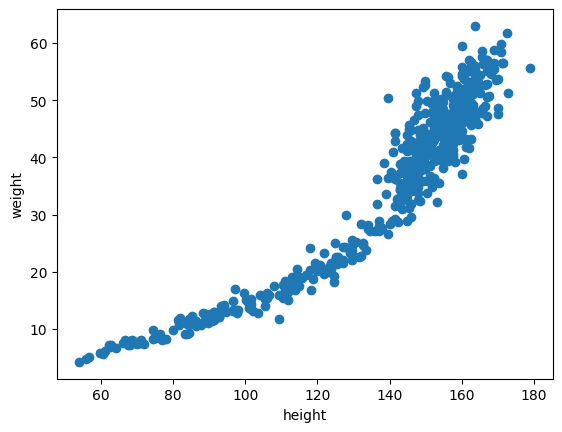

In [5]:
plt.scatter(howell['height'] , howell['weight'],)

#label axes
plt.xlabel("height")
plt.ylabel("weight")

**Task5**:

Create and run a stright line linear regression model on the howell data set with height predicting weight. Visualize your model and its posterior.

In [ ]:
with pm.Model() as model_lb:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * howell['height'])

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell['weight'])

    #inference data object
    idata_lb = pm.sample()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

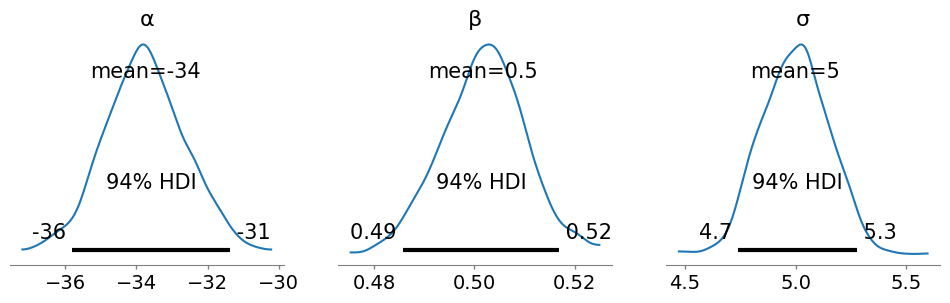

In [9]:
az.plot_posterior(idata_lb, var_names=["~μ"], figsize=(12, 3))

Text(0, 0.5, 'weight')

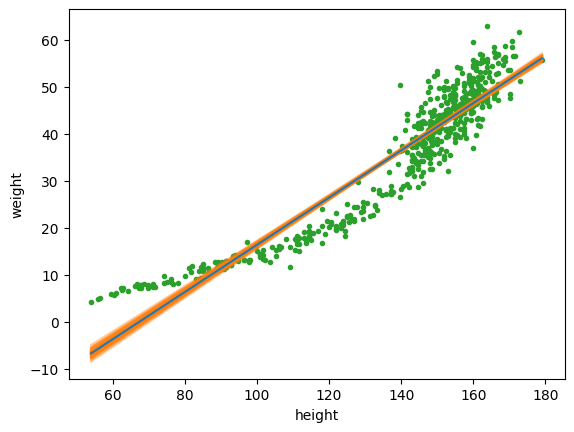

In [22]:
#grabs 100 posterior samples
posterior = az.extract(idata_lb, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(howell['height'].min(), howell['height'].max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(howell['height'], howell['weight'], "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("height")
ax.set_ylabel("weight")

**Task6**:

Run a posterior predictive check for model_howell, plot the posterior predictive distribution, and comment on the fit of the model you made in Task5.

In [ ]:
# posterior predictive check
pm.sample_posterior_predictive(idata_lb, model=model_lb,  extend_inferencedata=True)

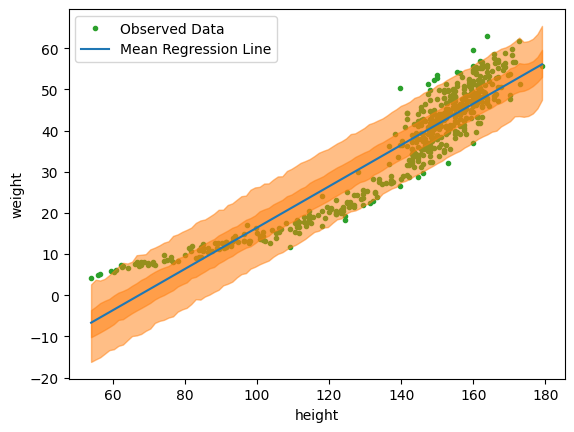

In [15]:
#plots the posterior predictive distribution

# grabs the expected line, or line of best fit formula
# This mean_line represents the average prediction for each observed height
mean_predictions = idata_lb.posterior["μ"].mean(("chain", "draw"))

# use howell['height'] and howell['weight']
height_data = howell['height'].values
weight_data = howell['weight'].values

# Create sorted index for plotting
idx = np.argsort(height_data)

# Create some x values to run through our line formula for interpolation
# using the range of howell['height']
x_interp = np.linspace(height_data.min(), height_data.max(), 100) # Use more points for smoother curve

# grabs the 94% HDI and 50% HDI for the posterior predictive distribution
y_pred_q = idata_lb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)

# sets up the HDIs for graphing
# PchipInterpolator expects strictly increasing x-values, so handle duplicates in height_data

y_hat_bounds_list = []
# Convert y_pred_q to numpy array for easier DataFrame creation
y_pred_q_values = y_pred_q.values

for i in range(4):
    # Create a temporary DataFrame to group by unique heights and average corresponding y_pred_q values
    temp_df = pd.DataFrame({'height': height_data, 'y_pred_val': y_pred_q_values[i]})
    grouped_data = temp_df.groupby('height')['y_pred_val'].mean().reset_index()

    unique_sorted_heights = grouped_data['height'].values
    averaged_y_pred_values = grouped_data['y_pred_val'].values

    # Now, unique_sorted_heights is strictly increasing
    interpolator = PchipInterpolator(unique_sorted_heights, averaged_y_pred_values)
    y_hat_bounds_list.append(interpolator(x_interp))

y_hat_bounds = iter(y_hat_bounds_list)


# plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(height_data, weight_data, "C2.", zorder=-3, label="Observed Data") # Plot original data

# Plot the mean regression line, sorted by height_data
ax.plot(height_data[idx], mean_predictions[idx], c="C0", label="Mean Regression Line")


# graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x_interp, lb, ub, color="C1", alpha=0.5)

# labels
ax.set_xlabel("height")
ax.set_ylabel("weight")
ax.legend() # Add a legend

<Axes: xlabel='y_pred'>

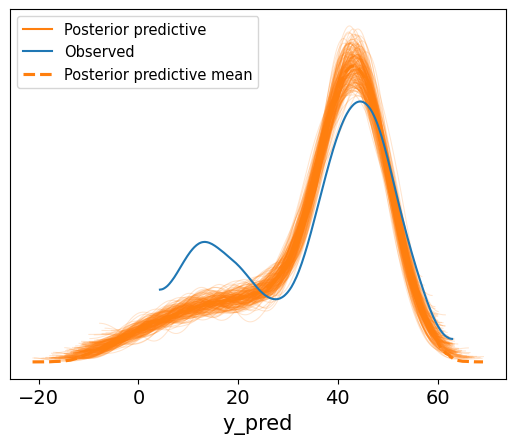

In [27]:
az.plot_ppc(idata_lb, num_pp_samples=200, colors=["C1", "C0", "C1"])

It fits it alright. For the linar model, the curve could be accounted for to make the fit better

**Task7**:

Create and visualize the posterior of a generalized linear model that improves the on the fit of the model you made in Task5.

In [ ]:
with pm.Model() as model_sqrtlb:

    #priors for our mean line
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * pm.math.sqrt(howell.height))

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=howell.weight)

    idata_sqrtlb = pm.sample()

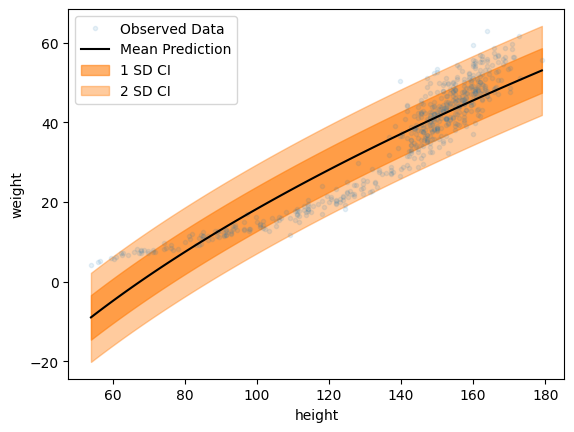

In [32]:
# Plots the posterior predictive for the model from Task 7 (model_sqrtlb)

_, ax = plt.subplots()

# Plot raw data
ax.plot(howell.height, howell.weight, "C0.", alpha=0.1, label="Observed Data")

# Extract posterior samples from idata_sqrtlb
posterior_sqrtlb = az.extract(idata_sqrtlb)

# Create a range of x-values for plotting the model fit
x_plot = np.linspace(howell.height.min(), howell.height.max(), 100)

# Calculate mean prediction for μ = α + β * sqrt(height)
# Convert scalar DataArray means to Python scalars using .item()
alpha_mean_scalar = posterior_sqrtlb["α"].mean().item()
beta_mean_scalar = posterior_sqrtlb["β"].mean().item()
μ_m_mean = alpha_mean_scalar + beta_mean_scalar * np.sqrt(x_plot)

# Get the mean of the standard deviation from the posterior
sigma_mean_scalar = posterior_sqrtlb["σ"].mean().item()

# Plot the mean line
ax.plot(x_plot, μ_m_mean, c="k", label="Mean Prediction")

# Plot 1 and 2 standard deviation credible intervals around the mean prediction
ax.fill_between(x_plot, μ_m_mean - 1 * sigma_mean_scalar, μ_m_mean + 1 * sigma_mean_scalar, alpha=0.6, color="C1", label="1 SD CI")
ax.fill_between(x_plot, μ_m_mean - 2 * sigma_mean_scalar, μ_m_mean + 2 * sigma_mean_scalar, alpha=0.4, color="C1", label="2 SD CI")

ax.set_xlabel("height")
ax.set_ylabel("weight")
ax.legend()

**Task8**:

Run a posterior predictive check, and visualize the posterior predictive distribution, for the model you made in Task7.

Comment on the fit.

In [ ]:
pm.sample_posterior_predictive(
    idata_sqrtlb, model = model_sqrtlb, extend_inferencedata=True
    )

<Axes: xlabel='y_pred'>

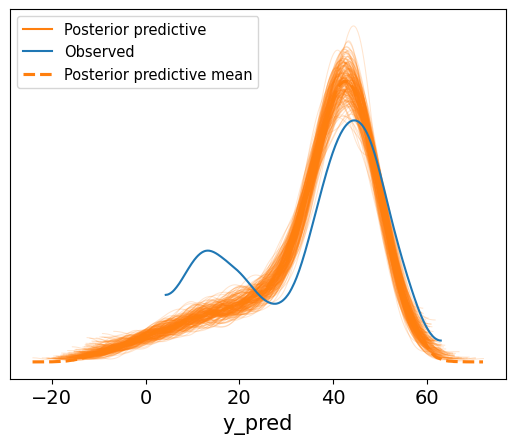

In [30]:
az.plot_ppc(idata_sqrtlb, num_pp_samples=200, colors=["C1", "C0", "C1"])

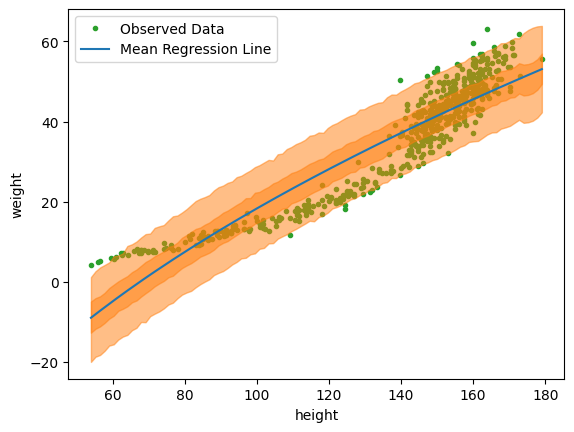

In [33]:
#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_sqrtlb.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
# Use howell['height'] data for x-axis
height_data = howell['height'].values
idx = np.argsort(height_data)
x = np.linspace(height_data.min(), height_data.max(), 100) # Use more points for smoother curve

#grabs the 94% HDI and 50% HDI for idata_sqrtlb
y_pred_q = idata_sqrtlb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)

#sets up the HDIs for graphing
y_hat_bounds_list = []
y_pred_q_values = y_pred_q.values

for i in range(4):
    temp_df = pd.DataFrame({'height': height_data, 'y_pred_val': y_pred_q_values[i]})
    grouped_data = temp_df.groupby('height')['y_pred_val'].mean().reset_index()
    unique_sorted_heights = grouped_data['height'].values
    averaged_y_pred_values = grouped_data['y_pred_val'].values
    interpolator = PchipInterpolator(unique_sorted_heights, averaged_y_pred_values)
    y_hat_bounds_list.append(interpolator(x))

y_hat_bounds = iter(y_hat_bounds_list)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(howell['height'], howell['weight'], "C2.", zorder=-3, label="Observed Data")
ax.plot(height_data[idx], mean_line[idx], c="C0", label="Mean Regression Line")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("height")
ax.set_ylabel("weight")
ax.legend()

It fits better! Probably because the curve is more accounted for so more of the data is actually predicted by the posterior predictive.